# Backtesting with zipline - Pipeline API with Custom Data

The backtesting engine Zipline used to power now-defunct Quantopian's online research, backtesting, and live (paper) trading platform. As a crowd-sourced hedge fund, Quantopian aimed to identify robust algorithms that outperform, subject to its risk management criteria. To this end, they used competitions to select the best strategies and allocate capital to share profits with the winners. Unfortunately, they closed down late 2020 but the open-source software packages remain available.

Zipline is designed to operate at the scale of thousands of securities, and each can be associated with a large number of indicators. It imposes more structure on the backtesting process than [backtrader](https://www.backtrader.com/) to ensure data quality by eliminating look-ahead bias, for example, and optimize computational efficiency while executing a backtest.

After installation, the command `zipline ingest -b quandl` lets you install the Quandl Wiki dataset (daily frequency) right away. The result ends up in the .zipline directory, which, by default, resides in your home folder. In addition, you can design your own bundles.

A shortcoming of bundles is that they do not let you store data other than price and volume information. However, two alternatives let you accomplish this: the `fetch_csv()` function downloads DataFrames from a URL and was designed for other Quandl data source. Zipline reasonably expects the data to refer to the same securities for which you have provided OHCLV data and aligns the bars accordingly. It's very easy to patch the library to load a local CSV or HDF5 using pandas.

In addition, `DataFrameLoader` and `BlazeLoader` permit you to feed additional attributes to a Pipeline. `BlazeLoader` can interface with numerous sources, including databases. However, since the Pipeline API is limited to daily data, `fetch_csv()` will be critical to adding features at a minute frequency such as our ML model predicitions.

## Imports & Settings

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline

from pathlib import Path
from collections import defaultdict
from time import time

import numpy as np
import pandas as pd
import pandas_datareader.data as web

from logbook import Logger, StderrHandler, INFO, WARNING

from zipline import run_algorithm
from zipline.api import (attach_pipeline, pipeline_output,
                         date_rules, time_rules, record,
                         schedule_function, commission, slippage,
                         set_slippage, set_commission, set_max_leverage,
                         order_target, order_target_percent,
                         get_open_orders, cancel_order)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders import USEquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_style('whitegrid')
idx = pd.IndexSlice
np.random.seed(42)

In [4]:
DATA_PATH = Path('..', 'data')

### Load zipline extensions

Only need this in notebook to find bundle.

In [5]:
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [6]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=WARNING)
log_handler.push_application()
log = Logger('Algorithm')

## Algo Params

We'll now illustrate how to load the LightGBM model daily return predictions, together with price data for our universe, into a pipeline and use a CustomFactor to select the top and bottom 10 predictions as long and short positions, respectively. 

Our goal is to combine the daily return predictions with the OHCLV data from our Quandl bundle, and then to go long on up to 10 equities with the highest predicted returns and short on those with the lowest predicted returns, requiring at least five stocks on either side, similar to the backtrader example above.

In [7]:
N_LONGS = 10
N_SHORTS = 10
MIN_POSITIONS = 5

## Load Data

### Quandl Wiki Bundle

In [8]:
bundle_data = bundles.load('quandl')

### ML Predictions

In [9]:
def load_predictions(bundle):
    """combine the daily return predictions with the OHCLV data from our Quandl bundle"""
    predictions = pd.read_hdf('predictions.h5', 'gradient_boosting')
    
    predictions = predictions[~predictions.index.duplicated()]
    tickers = predictions.index.get_level_values('ticker').unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))

    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .tz_localize('UTC')), assets

In [10]:
predictions, assets = load_predictions(bundle_data)

In [11]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 2014-01-09 00:00:00+00:00 to 2016-12-29 00:00:00+00:00
Columns: 500 entries, 0 to 3193
dtypes: float64(500)
memory usage: 2.9 MB


### Define Custom Dataset

To make the predictions available to the Pipeline API, we need to define a `Column` with a suitable data type for a `DataSet` with an appropriate domain:

In [12]:
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

### Define Pipeline Loaders

While the bundle's OHLCV data can rely on the built-in `USEquityPricingLoader`, we need to define our own `DataFrameLoader`, as follows:

In [13]:
signal_loader = {SignalData.predictions:
                     DataFrameLoader(SignalData.predictions, predictions)}

In fact, we need to slightly modify the Zipline library's source code to bypass the assumption that we will only load price data. To this end, we add a `custom_loader` parameter to the `run_algorithm` method below and ensure that this loader is used when the pipeline needs one of `SignalData`'s `Column` instances.

## Pipeline Setup

The Pipeline API facilitates the definition and computation of alpha factors for a cross-section of securities from historical data. Pipeline significantly improves efficiency because it optimizes computations over the entire backtest period, rather than tackling each event separately. In other words, it continues to follow an event-driven architecture but vectorizes the computation of factors where possible.

A pipeline uses factors, filters, and classifiers classes to define computations that produce columns in a table with point-in-time values for a set of securities. Factors take one or more input arrays of historical bar data and produce one or more outputs for each security. There are numerous built-in factors, and you can also design your own `CustomFactor` computations (which may include training and retrieving predictions form an ML model).

### Custom ML Factor

Our pipeline is going to have two Boolean columns that identify the assets we would like to trade as long and short positions. To get there, we first define a `CustomFactor` called `MLSignal` that just receives the current return predictions. 

The motivation is to allow us to use some of the convenient `Factor` methods designed to rank and filter securities:

In [14]:
class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, predictions):
        out[:] = predictions

### Create Pipeline

Now, we can set up our actual pipeline by instantiating `CustomFactor`, which requires no arguments other than the defaults provided. We combine its `top()` and `bottom()` methods with a filter to select the highest positive and lowest negative predictions:

In [15]:
def compute_signals():
    signals = MLSignal()
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets))

## Initialize Algorithm

The `TradingAlgorithm` class implements the Zipline Algorithm API and operates on `BarData` that has been aligned with a given trading calendar. After the initial setup, the backtest runs for a specified period and executes its trading logic as specific events occur. 

These events are driven by the daily or minutely trading frequency, but you can also schedule arbitrary functions to evaluate signals, place orders, and rebalance your portfolio, or log information about the ongoing simulation.

You can execute an algorithm from the command line, in a Jupyter Notebook, or by using the `run_algorithm()` method of the underlying `TradingAlgorithm` class. The algorithm requires an `initialize()` method that is called once when the simulation starts. It keeps state through a context dictionary and receives actionable information through a data variable containing point-in-time current and historical data.

You need to register your pipeline with the `initialize()` method and execute it at each time step or on a custom schedule.

In [16]:
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets
    context.trades = pd.Series()
    context.longs = context.shorts = 0
    
    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0.001, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
#                       date_rules.week_start(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

### Get daily Pipeline results

The following method processes the Pipeline output every day before trading starts. 

In [17]:
def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    df = (output['longs'].astype(int)
                      .append(output['shorts'].astype(int).mul(-1)))
    
    holdings = df[df!=0]
    other = df[df==0]
    other = other[~other.index.isin(holdings.index) & ~other.index.duplicated()]
    context.trades = holdings.append(other)
    assert len(context.trades.index.unique()) == len(context.trades)

## Define Rebalancing Logic

After the market opens, we place orders for our long and short targets and close all other positions:

In [18]:
def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)
    for symbol, open_orders in get_open_orders().items():
        for open_order in open_orders:
            cancel_order(open_order)
      
    positions = context.portfolio.positions
    s=pd.Series({s:v.amount*v.last_sale_price for s, v in positions.items()}).sort_values(ascending=False)
    for stock, trade in context.trades.items():
        if trade == 0:
            order_target(stock, target=0)
        else:
            trades[trade].append(stock)
    
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
#     log.warning('{} {:,.0f}'.format(len(positions), context.portfolio.portfolio_value))
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)
    else:
        for stock in trades[-1] + trades[1]:
            if stock in positions:
                order_target(stock, 0)

## Record Data Points

In [19]:
def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

## Run Algorithm

Now, we are ready to execute our backtest and pass the results to `pyfolio`:

In [20]:
dates = predictions.index.get_level_values('date')
start_date, end_date = dates.min(), dates.max()

In [21]:
print('Start: {}\nEnd:   {}'.format(start_date.date(), end_date.date()))

Start: 2014-01-09
End:   2016-12-29


In [22]:
start = time()
results = run_algorithm(start=pd.Timestamp('2014-01-12', tz='UTC'),
                        end=end_date,
                        initialize=initialize,
                        before_trading_start=before_trading_start,
                        capital_base=1e5,
                        data_frequency='daily',
                        bundle='quandl',
                        custom_loader=signal_loader)  # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

Duration: 30.06s


## PyFolio Analysis

In [23]:
benchmark = web.DataReader('SP500', 'fred', '2013', '2017').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

In [24]:
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results['2011':'2016'])

### Custom Plots

The following plots display the cumulative returns of our backtest, which outperform the S&P500 during the second half of the sample period. The right-hand plot shows the 3-months rolling average of the Sharpe ratio:

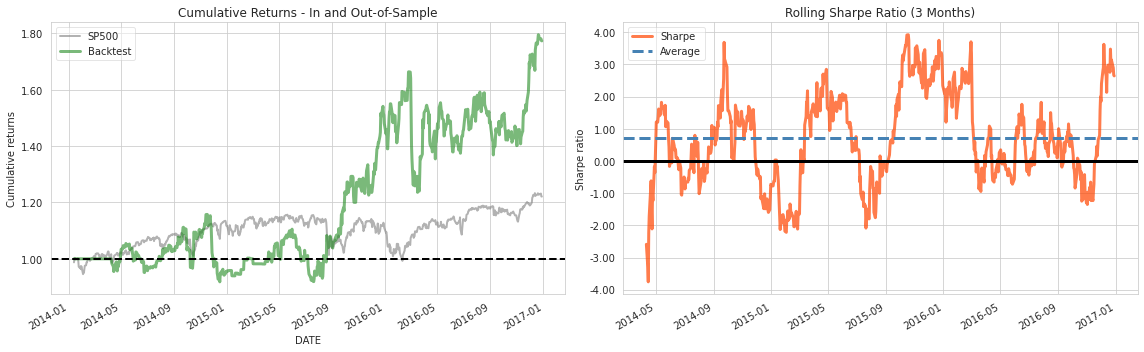

In [25]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                     ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
fig.tight_layout()

### Tear Sheets

The PyFolio tearsheet displays numerous performance metrics for the sample period:

Start date,2014-01-13
End date,2016-12-29
Total months,35
,Backtest
Annual return,21.287%
Cumulative returns,77.331%
Annual volatility,29.036%
Sharpe ratio,0.81
Calmar ratio,0.83
Stability,0.74
Max drawdown,-25.712%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.71,2016-02-26,2016-03-17,2016-11-30,199
1,20.67,2014-11-17,2014-12-16,2015-09-25,225
2,13.09,2014-09-23,2014-10-14,2014-11-11,36
3,9.79,2014-05-13,2014-06-25,2014-09-11,88
4,9.79,2015-12-28,2016-01-08,2016-01-14,14


Stress Events,mean,min,max
Apr14,0.08%,-2.16%,2.37%
Oct14,0.14%,-5.78%,9.32%
Fall2015,0.61%,-3.04%,9.52%
New Normal,0.09%,-8.61%,9.52%


Top 10 long positions of all time,max
sid,
GRMN,17.30%
HSY,17.29%
CRM,17.26%
CREE,17.21%
CPB,17.19%
MYL,17.15%
HRB,17.01%
WYNN,16.95%
SUNE,16.94%


Top 10 short positions of all time,max
sid,
UPL,-20.19%
ACI,-19.60%
WLT,-18.84%
ANR,-18.73%
PTEN,-17.96%
MRO,-17.31%
APC,-17.31%
ED,-17.14%
SO,-17.08%


Top 10 positions of all time,max
sid,
UPL,20.19%
ACI,19.60%
WLT,18.84%
ANR,18.73%
PTEN,17.96%
MRO,17.31%
APC,17.31%
GRMN,17.30%
HSY,17.29%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,9877.00,4945.00,4932.00
Percent profitable,0.50,0.50,0.51
Winning round_trips,4973.00,2479.00,2494.00
Losing round_trips,4792.00,2404.00,2388.00
Even round_trips,112.00,62.00,50.00


PnL stats,All trades,Short trades,Long trades
Total profit,$96710.80,$71228.90,$25481.90
Gross profit,$1421241.29,$753073.25,$668168.04
Gross loss,$-1324530.49,$-681844.34,$-642686.14
Profit factor,$1.07,$1.10,$1.04
Avg. trade net profit,$9.79,$14.40,$5.17
Avg. winning trade,$285.79,$303.78,$267.91
Avg. losing trade,$-276.40,$-283.63,$-269.13
Ratio Avg. Win:Avg. Loss,$1.03,$1.07,$1.00
Largest winning trade,$7722.48,$7722.48,$7354.11
Largest losing trade,$-10159.05,$-10159.05,$-5592.09


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 22:29:56.172117039,1 days 23:56:36.885136501,1 days 21:03:01.750811030
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,266 days 04:00:01,266 days 04:00:01,20 days 00:00:00
Shortest duration,0 days 03:00:01,0 days 03:00:01,0 days 03:00:01


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.01%,0.01%,0.01%
Avg returns winning,0.22%,0.22%,0.23%
Avg returns losing,-0.21%,-0.21%,-0.22%
Median returns all round_trips,0.00%,0.00%,0.00%
Median returns winning,0.12%,0.12%,0.13%
Median returns losing,-0.12%,-0.12%,-0.12%
Largest winning trade,7.44%,7.44%,4.87%
Largest losing trade,-7.51%,-4.17%,-7.51%


Symbol stats,A,AAL,AAP,AAPL,ABC,ABT,ACI,ACN,ADBE,ADI,ADM,ADP,ADS,ADSK,AEO,AEP,AES,AET,AFL,AGCO,AGN,AIG,AKAM,AKS,ALL,ALTR,ALXN,AMAT,AMD,AMG,AMGN,AMP,AMT,AMTD,AMZN,ANF,ANR,ANTM,AON,APA,APC,APD,APH,APOL,ARNC,ASH,ATI,ATVI,AVB,AVP,AXP,AZO,BA,BAC,BAX,BBBY,BBT,BBY,BCR,BDX,BEAM,BEN,BG,BHI,BIDU,BIIB,BK,BLK,BMRN,BMY,BP,BRCD,BRCM,BSX,BTU,BWA,BXP,C,CA,CAG,CAH,CAM,CAT,CB,CBG,CBS,CCE,CCI,CCL,CE,CELG,CERN,CF,CHK,CHKP,CHRW,CI,CIEN,CL,CLF,CLR,CLX,CMA,CMCSA,CMCSK,CME,CMG,CMI,CMS,CNP,CNX,COF,COG,COH,COL,COP,COST,CPB,CPN,CREE,CRM,CSCO,CSX,CTL,CTSH,CTXS,CVS,CVX,CXO,D,DAL,DD,DE,DECK,DF,DFS,DGX,DHI,DHR,DIS,DISCA,DISH,DKS,DLTR,DNR,DO,DOV,DOW,DPS,DRI,DTE,DTV,DUK,DVA,DVN,EA,EBAY,ECL,ED,EIX,EL,EMC,EMN,EMR,ENDP,EOG,EQIX,EQR,EQT,ESRX,ESV,ETFC,ETN,ETR,EW,EXC,EXPD,EXPE,F,FAST,FCX,FDO,FDX,FE,FFIV,FIS,FISV,FITB,FL,FLR,FLS,FOX,FOXA,FRX,FSLR,FTI,GD,GE,GGP,GILD,GIS,GLW,GMCR,GME,GNW,GOOGL,GPS,GRMN,GS,GT,GWW,HAL,HAS,HBAN,HCN,HCP,HD,HES,HFC,HIG,HOG,HOLX,HON,HOT,HP,HPQ,HRB,HSH,HST,HSY,HTZ,HUM,IACI,IBM,ICE,IGT,ILMN,INTC,INTU,IP,IPG,IR,ISRG,IVZ,JBHT,JBLU,JCI,JCP,JDSU,JEC,JNJ,JNPR,JOY,JPM,JWN,K,KBH,KEY,KIM,KLAC,KMB,KMX,KO,KR,KSS,KSU,L,LB,LBTYA,LEN,LH,LINTA,LLL,LLTC,LLY,LM,LMT,LNC,LOW,LRCX,LUV,LVLT,LVS,M,MA,MAS,MAT,MCD,MCHP,MCK,MCO,MDLZ,MDT,MET,MGM,MHK,MJN,MLM,MMC,MMM,MNST,MO,MON,MOS,MRK,MRO,MRVL,MS,MSFT,MSI,MTB,MU,MUR,MXIM,MYL,NBL,NBR,NDAQ,NE,NEE,NEM,NFLX,NFX,NKE,NLY,NOC,NOV,NRG,NSC,NTAP,NTRS,NUAN,NUE,NVDA,NWL,OCR,OMC,ONNN,ORCL,ORLY,OXY,PAYX,PCAR,PCG,PCLN,PCP,PEG,PEP,PETM,PFE,PFG,PG,PGR,PH,PHM,PLD,PM,PNC,PNRA,PPG,PPL,PRGO,PRU,PSA,PTEN,PVH,PWR,PX,PXD,QCOM,RAI,RCL,RDC,RF,RHT,RIG,RL,ROK,ROST,RRC,RSG,RTN,RVBD,S,SBAC,SBUX,SCCO,SCHW,SE,SHW,SIAL,SIRI,SLB,SLG,SLM,SNDK,SO,SPG,SPLS,SRE,STI,STJ,STLD,STT,STX,STZ,SUNE,SWK,SWKS,SWN,SWY,SYK,SYMC,SYY,T,TAP,TDC,TEL,TEX,TGT,THC,TIF,TJX,TMO,TMUS,TOL,TROW,TRV,TSN,TSO,TWC,TWX,TXN,TXT,TYC,UAA,UAL,UHS,UNH,UNM,UNP,UPL,UPS,URBN,URI,USB,UTHR,UTX,V,VAR,VFC,VIAB,VLO,VMC,VMW,VNO,VOD,VRSN,VRTX,VRX,VTR,WAG,WAT,WBA,WDC,WFC,WFM,WHR,WLL,WLT,WM,WMB,WMT,WSM,WU,WY,WYN,WYNN,X,XEC,XEL,XLNX,XRX,YHOO,YUM,ZBH,ZION,ZMH
Avg returns all round_trips,0.05%,-0.05%,-0.01%,0.00%,0.06%,0.10%,0.02%,0.03%,-0.05%,0.18%,0.10%,-0.04%,0.16%,-0.01%,0.03%,-0.05%,0.07%,-0.03%,0.13%,-0.04%,0.05%,-0.05%,0.01%,-0.01%,0.12%,-0.09%,-0.06%,0.00%,0.02%,-0.04%,-0.06%,-0.03%,-0.05%,0.20%,-0.01%,-0.01%,-0.01%,0.04%,0.08%,-0.06%,0.01%,0.13%,0.01%,0.01%,-0.02%,NaN,0.04%,-0.01%,NaN,0.03%,0.01%,-0.23%,0.08%,0.10%,0.11%,0.04%,0.02%,-0.08%,0.03%,-0.05%,0.10%,0.14%,0.11%,-0.03%,0.06%,-0.04%,0.00%,0.02%,0.01%,0.05%,-0.08%,0.04%,-0.00%,0.05%,-0.00%,0.25%,-0.10%,-0.08%,-0.01%,-0.08%,-0.10%,0.00%,-0.17%,0.04%,-0.06%,-0.07%,-0.00%,-0.11%,0.12%,-0.24%,-0.08%,-0.05%,0.00%,0.10%,0.33%,0.03%,-0.03%,0.02%,0.04%,0.03%,0.01%,-0.15%,-0.15%,0.00%,0.16%,0.09%,-0.43%,0.17%,-0.65%,-0.04%,-0.01%,-0.16%,-0.01%,-0.13%,-0.09%,0.11%,-0.50%,0.10%,0.07%,0.02%,-0.05%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74%,0.10%,0.02%,0.01%,0.00%,0.14%,0.03%,-0.04%,-0.47%,-0.06%,-0.05%,0.15%,0.40%,0.11%,0.35%,0.16%,-0.01%,0.02%,0.13%,0.05%,0.27%,-0.18%,0.03%,-0.02%,0.17%,-0.05%,0.01%,-0.05%,-0.07%,-0.04%,0.00%,NaN,-0.07%,0.10%,0.01%,NaN,0.21%,0.11%,NaN,-0.01%,-0.05%,0.02%,-0.10%,-0.18%,0.03%,0.16%,-0.12%,0.05%,-0.24%,0.16%,NaN,-0.27%,0.20%,-0.20%,0.14%,-0.10%,0.07%,0.01%,0.12%,-0.41%,-0.29%,0.04%,-0.24%,-0.06%,0.06%,0.13%,0.03%,-0.05%,-0.01%,0.25%,0.63%,0.09%,-0.15%,-0.04%,-0.22%,-0.03%,-0.14%,-0.01%,0.02%,0.06%,0.01%,0.06%,0.03%,-0.12%,0.14%,0.02%,0.03%,0.08%,0.07%,-0.14%,-0.21%,0.01%,0.07%,0.07%,0.02%,0.41%,0.09%,0.18%,0.13%,0.25%,0.01%,0.17%,-0.05%,0.06%,-0.08%,NaN,NaN,0.03%,-0.05%,0.11%,0.13%,0.03%,0.10%,-0.14%,-0.03%,0.10%,0.02%,0.06%,0.04%,-0.14%,0.22%,-0.35%,-0.58%,0.18%,0.10%,0.12%,-0.00%,0.10%,-0.51%,0.00%,-0.14%,0.07%,-0.09%,0.04%,-0.01%,0.02%,0.18%,-0.01%,-0.04%,0.08%,-0.18%,-0.02%,-0.13%,0.07%,0.11%,0.18%,NaN,-0.17%,0.19%,NaN,NaN,NaN,NaN,NaN,0.35%,-0.02%,0.15%,0.14%,0.23%,-0.17%,0.03%,0.31%,0.04%,0.24%,0.07%,-0.04%,0.13%,0.08%,NaN,0.00%,-0.26%,0.01%,-0.34%,-0.12%,-0.02%,0.21%,0.04%,0.06%,0.

Profitability (PnL / PnL total) per name,
symbol,
AMD,18.29%
ACI,16.03%
AVP,11.84%
CLF,11.00%
S,9.05%
DO,8.63%
ANR,8.46%
THC,7.98%
CHK,7.45%


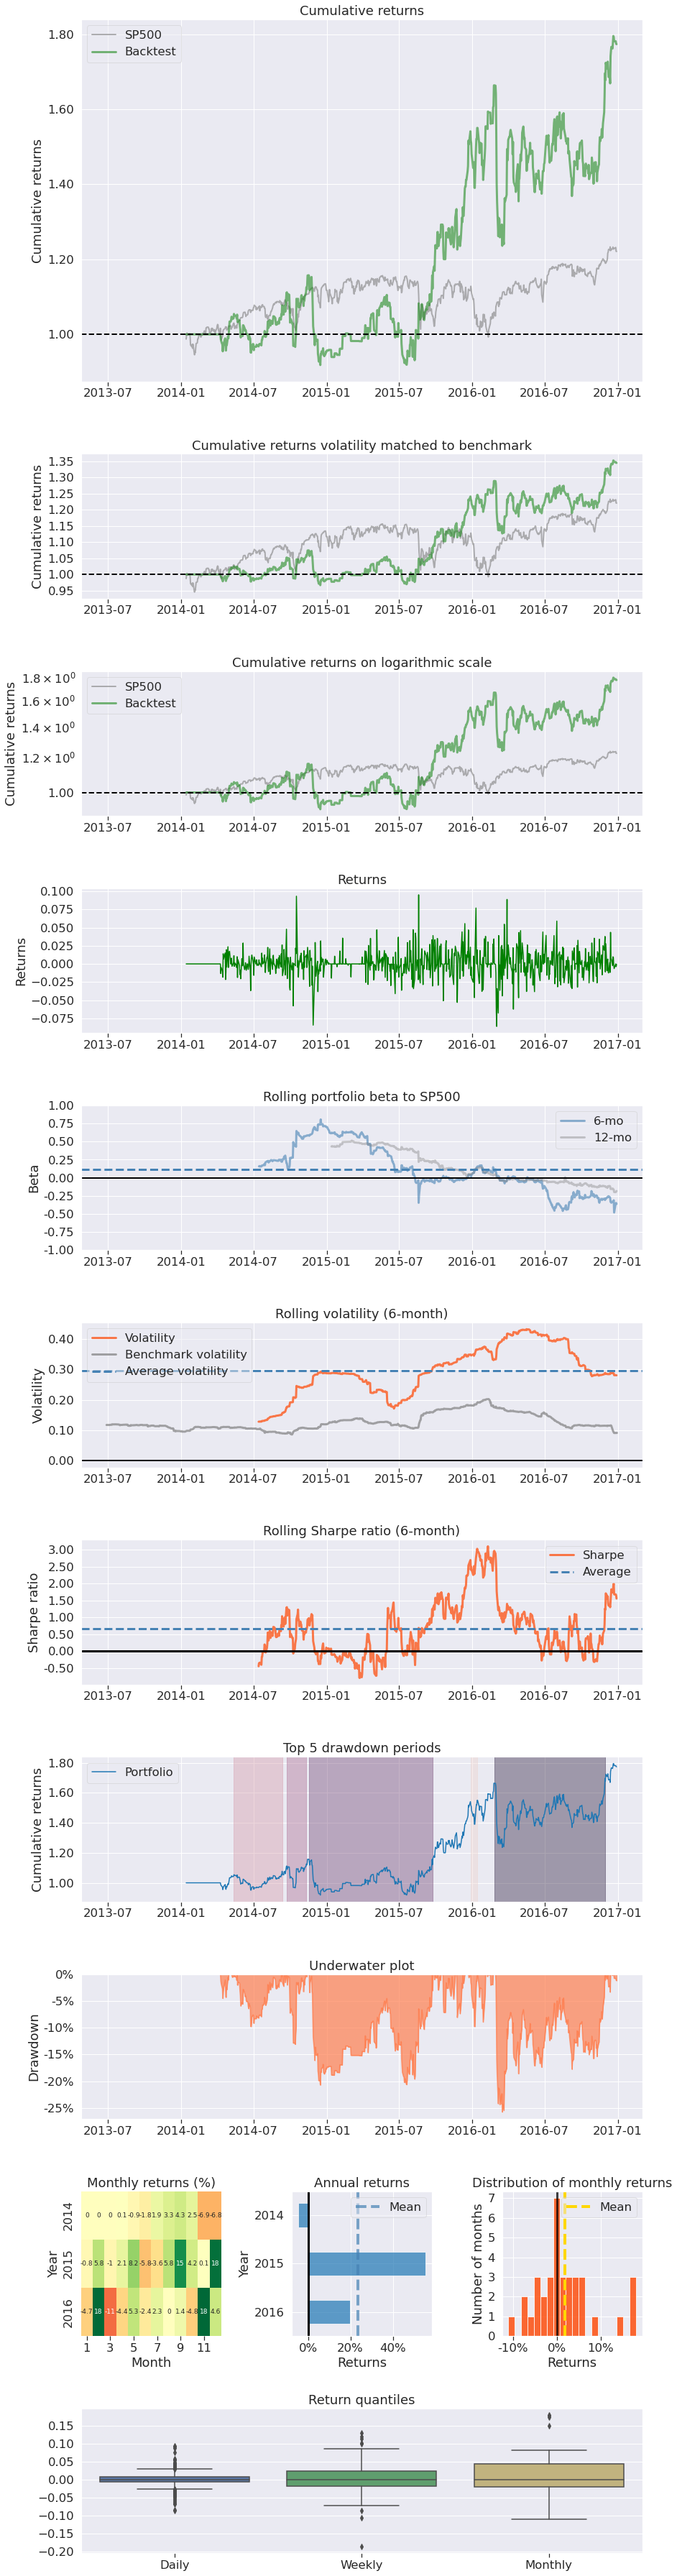

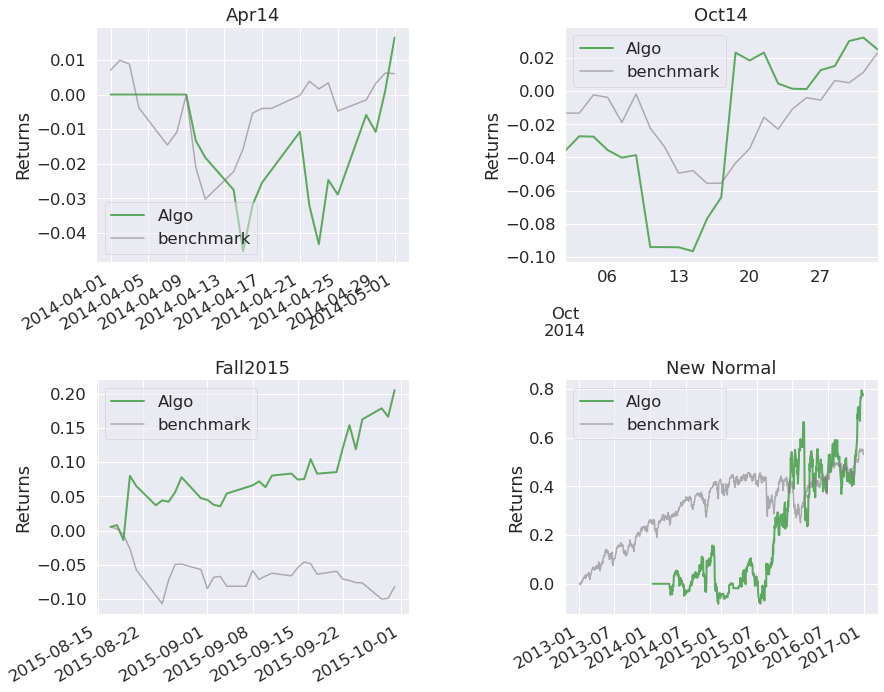

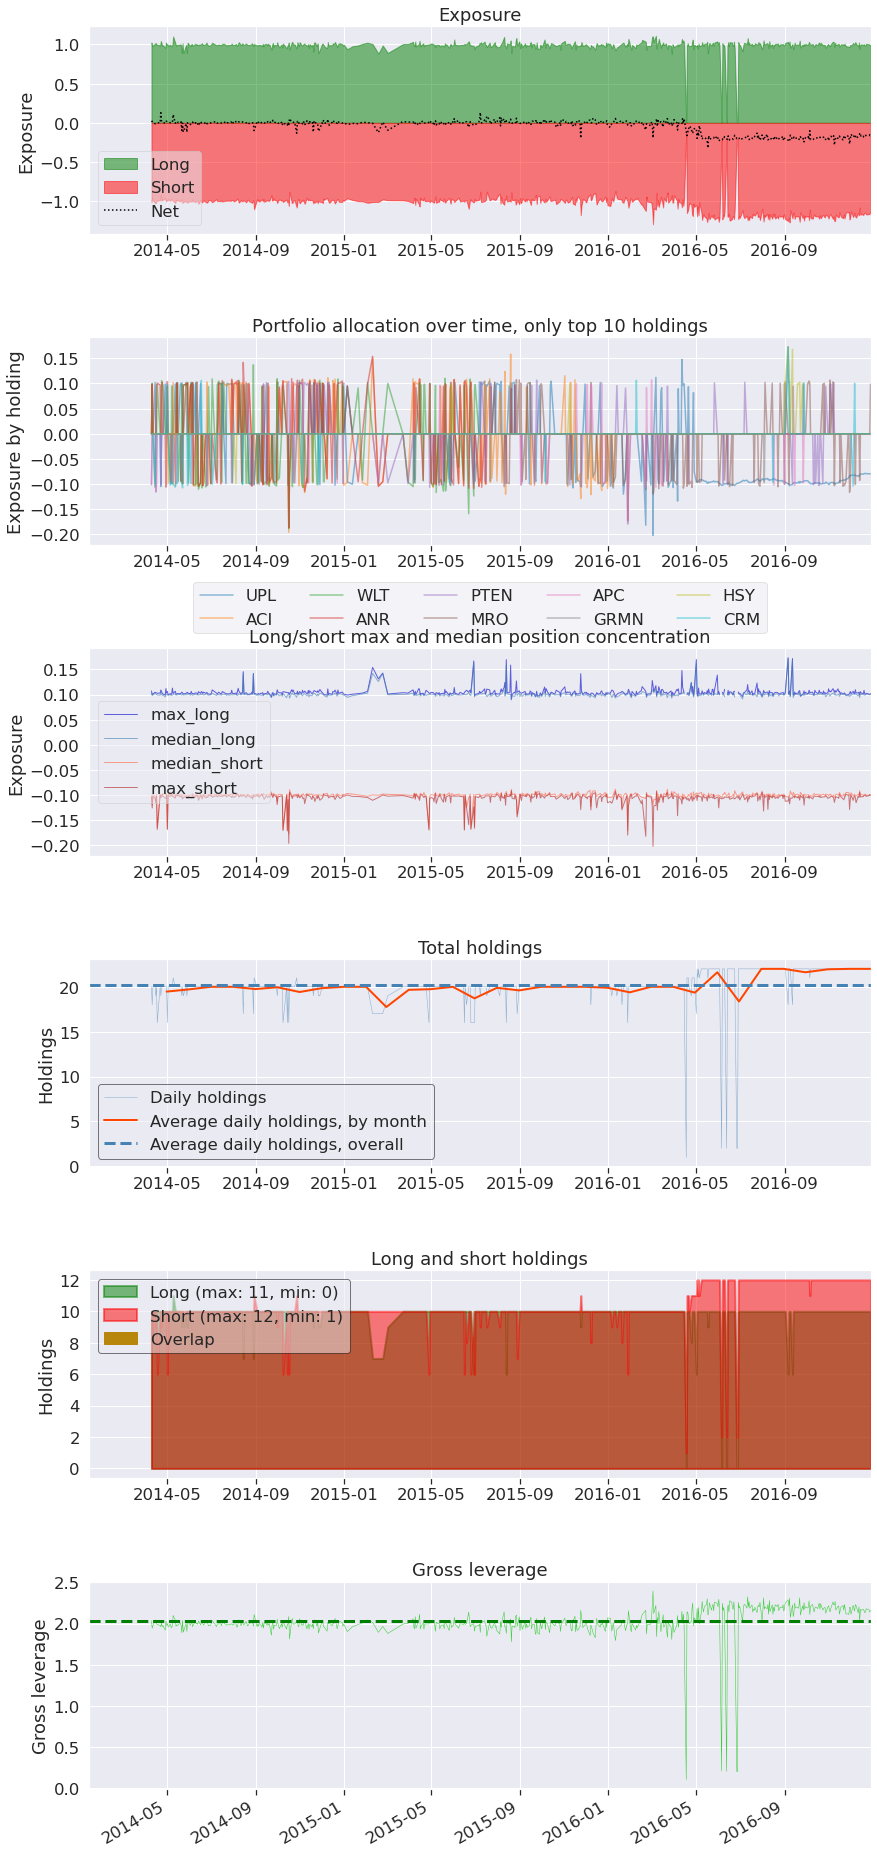

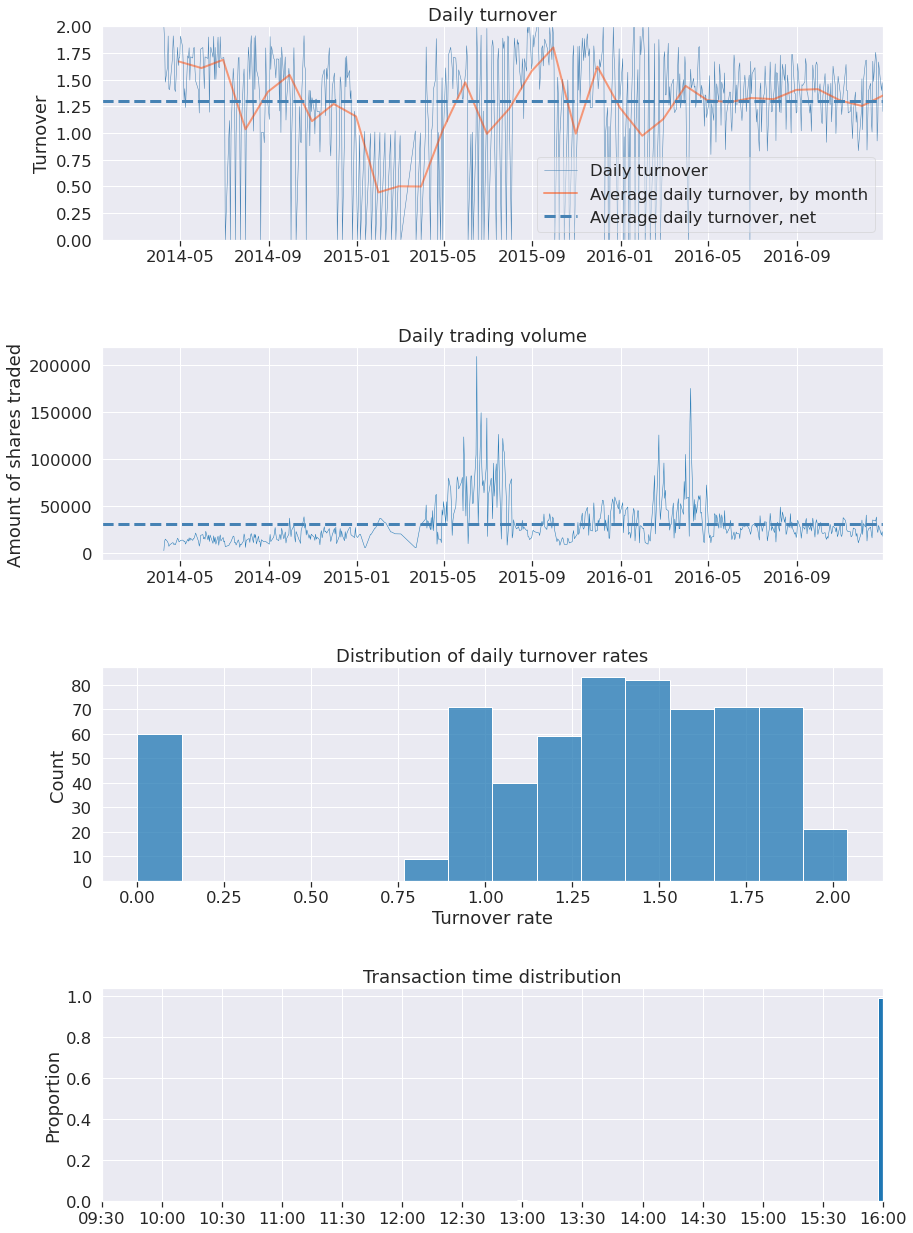

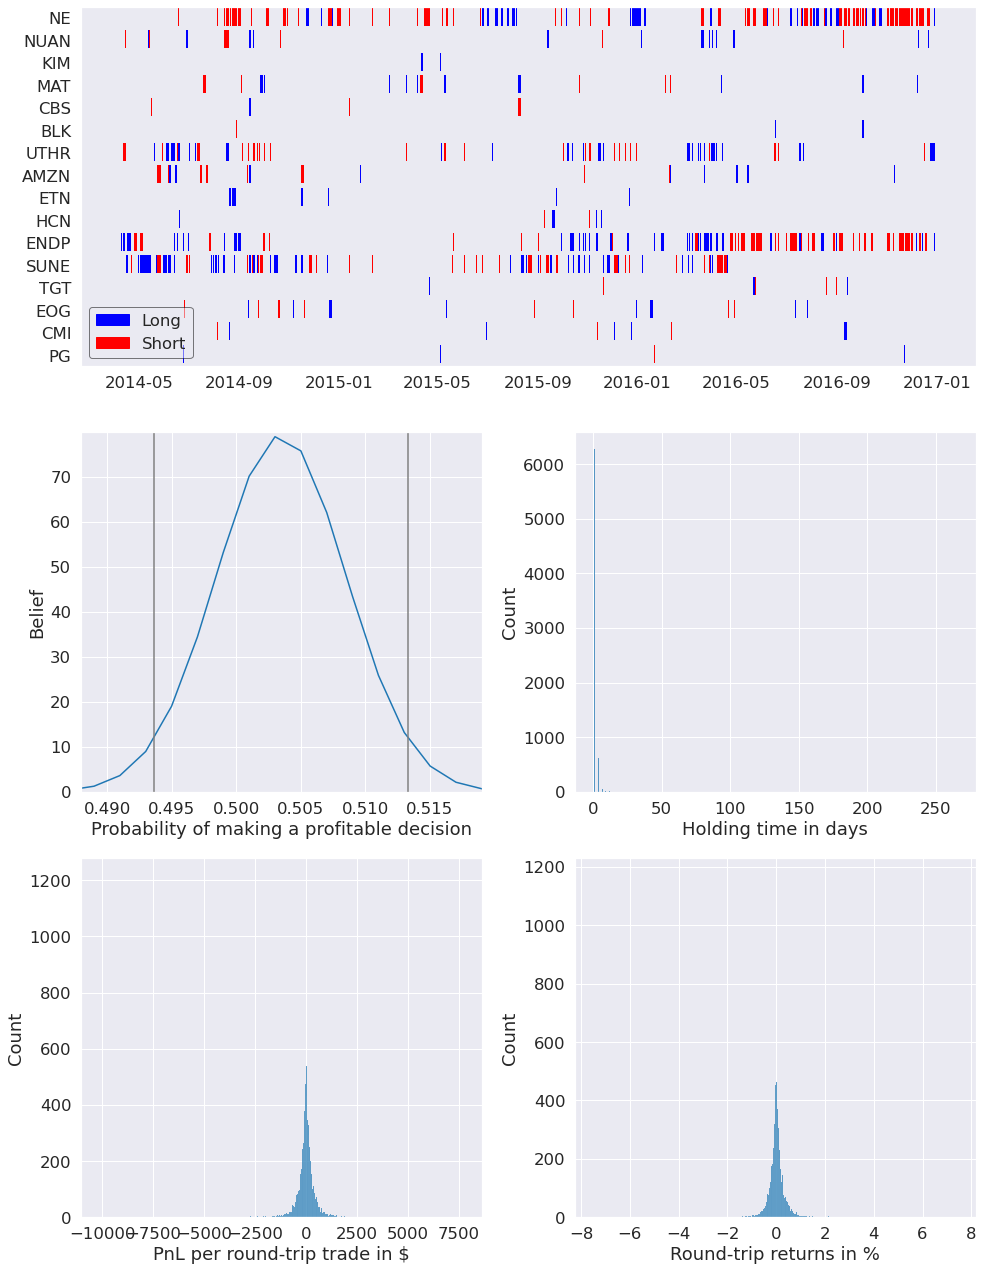

In [26]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          round_trips=True)